In [57]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import Aer
from qiskit.aqua.utils import split_dataset_to_data_and_labels
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.circuit.library import ZZFeatureMap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [71]:
Titanic_DF = pd.read_csv('titanic.csv')
Titanic_DF = Titanic_DF.drop(['PassengerId','Name','Cabin','Ticket'],axis=1)

In [75]:
lb_make = preprocessing.LabelEncoder()
Titanic_DF['Sex'] = lb_make.fit_transform(Titanic_DF['Sex'])
Titanic_DF['Embarked'] = lb_make.fit_transform(Titanic_DF['Embarked'])

le_name_mapping = dict(zip(lb_make.classes_, lb_make.transform(lb_make.classes_)))

pd.DataFrame(Titanic_DF).fillna(inplace=True, method='backfill')

FeatureNames = [x for x in list(Titanic_DF.columns) if x not in ['Name','Survived']]
Data = Titanic_DF[FeatureNames].values
Labels = Titanic_DF['Survived'].values

In [76]:
Titanic_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


In [77]:
Titanic_DF

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2
887,1,1,0,19.0,0,0,30.0000,2
888,0,3,0,26.0,1,2,23.4500,2
889,1,1,1,26.0,0,0,30.0000,0


In [87]:
feature_dim=2
class_labels = [r'0', r'1']

In [88]:
sample_train, sample_test, label_train, label_test = train_test_split(Data, Labels, test_size=0.3, random_state=12)

In [89]:
std_scale = StandardScaler().fit(sample_train, label_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

In [96]:
pca = PCA(n_components=feature_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

In [85]:
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

In [97]:
sample_test

array([[-4.83865324e+00,  3.58980919e+01],
       [ 2.47039145e+00, -1.42680618e+01],
       [-2.44787633e+01, -7.67900619e+00],
       [ 1.98317457e+01,  1.31964612e+00],
       [-2.37415019e+01, -7.69582358e+00],
       [-4.90694657e+00,  3.28996839e+01],
       [-2.43283573e+01,  1.53139576e+01],
       [-1.97888595e+01, -1.79984213e+00],
       [ 7.60312952e-01, -1.25244840e+00],
       [-2.08925483e+01, -7.76409484e+00],
       [ 1.40476233e+01, -2.86589103e+01],
       [-2.42272356e+01,  4.31604000e+00],
       [-1.68044268e+01,  1.81584424e+01],
       [-8.04672057e+00,  9.16191835e-01],
       [-1.35925314e+01, -2.82221370e+01],
       [-1.10996834e+01,  5.01237558e+00],
       [-1.89858954e+01,  1.02082943e+01],
       [-1.22793493e+01, -2.79940303e+01],
       [-2.49661120e+01,  1.33292844e+00],
       [-2.45079539e+01, -7.67834033e+00],
       [-6.30573545e+00, -1.06802112e+00],
       [-1.82527161e+01,  4.19255897e+00],
       [-2.38302216e+01,  1.53059379e+01],
       [-1.

In [91]:
def QuantumFormat(sample_train, sample_test, label_train, label_test, training_size, test_size, class_labels):
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size] for k, key in enumerate(class_labels)}
    return training_input, test_input

In [98]:
training_input, test_input = QuantumFormat(sample_train, sample_test, label_train, label_test, 10, 10, class_labels)
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

In [100]:
training_input, test_input

({'0': array([[-25.12126446,  -5.66345262],
         [-17.21502634,  -3.84474216],
         [-21.84931787,  -5.7262068 ],
         [-21.64443789,   3.26901713],
         [  7.42929736,   1.11956625],
         [-22.49241577,  11.25603793],
         [-24.40476151,   8.31624054],
         [-22.59781783,  -8.74132972],
         [-24.37136723,  -1.68152438],
         [ 24.23567738,  -1.79029272]]),
  '1': array([[-24.60792154,  -7.67606001],
         [ 56.31855183, -26.51475528],
         [-24.46762598, -12.67920322],
         [480.13388227,  -4.17362704],
         [ -2.47785866, -15.18648808],
         [  4.15920907, -28.33919576],
         [-13.06232934,  -4.97321339],
         [ -9.46239434, -11.02249112],
         [-25.2918694 ,  -1.66052715],
         [-24.56460234,  -9.67990814]])},
 {'0': array([[ -4.83865324,  35.89809191],
         [  2.47039145, -14.2680618 ],
         [-24.47876333,  -7.67900619],
         [ 19.83174573,   1.31964612],
         [-23.74150188,  -7.69582358],
     

In [102]:

# QSVM
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, None)
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = qsvm.run(quantum_instance)
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

MissingOptionalLibraryError: "The 'CVXPY' library is required to use 'optimize_svm'. You can install it with 'pip install qiskit-aqua[cvx]'."

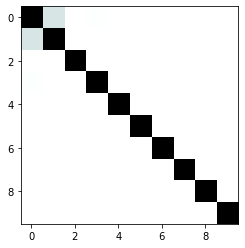

Error rate: 0.6194029850746269


In [103]:

# Classical SVM
svc = SVC(probability=True, gamma='auto')
svc.fit(sample_train, label_train)
kernel_matrix2=sklearn.metrics.pairwise.rbf_kernel(sample_train, sample_train)
img = plt.imshow(np.asmatrix(kernel_matrix2[0:10,0:10]),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

# Error Rate
label_predict=svc.predict(sample_test)
print('Error rate: ' + str(sum(label_predict==label_test)/len(label_predict)))